In [0]:
# Imports
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [16]:
# Get data
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-04-29 16:47:29--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.02s   

2020-04-29 16:47:30 (29.2 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [17]:
# Data is strange because of off kaggle encoding
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")

# Clean up data
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["lables", "data"]
df.head()

,lables,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
# Create binary lables for tensorflow from ham/spam lables
df["b_lables"] = df["lables"].map({"ham": 0, "spam": 1})
Y = df["b_lables"].values
df.head()

,lables,data,b_lables
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [0]:
# Split the data
df_train, df_test, y_train, y_test = train_test_split(df["data"], Y, test_size=0.33)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000

# Only train the tokenizer on the words in the training data.  Makes it easyer for the model to process new data
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)

sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [21]:
# Get word -> int mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print("Found %s unique tokens." %V)

Found 7198 unique tokens.


In [22]:
# Pad sequences to get a N x T array
data_train = pad_sequences(sequences_train)
data_test = pad_sequences(sequences_test)

T = data_train.shape[1]

print("Training data shape: ", data_train.shape)
print("Testing data shape: ", data_test.shape)

Training data shape:  (3733, 162)
Testing data shape:  (1839, 180)


In [0]:
# Create the model

    # Choose embedding dimensionality
D = 20
    # Hidden state dimensionality
M = 15

i = Input(shape=(T,))
    # Embeding size is V+1 because it starts counting at 1 (0 used for padding)
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)   # Also try with return_sequences as false and no pooling
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.001),
    metrics=["accuracy"]
)

In [24]:
# Train the model
r = model.fit(
    data_train,
    y_train,
    epochs=10,
    validation_data=(data_test, y_test)
)

Epoch 1/10
117/117 [==============================] - 2s 15ms/step - loss: 0.4525 - accuracy: 0.8682 - val_loss: 0.3500 - val_accuracy: 0.8608
Epoch 2/10
117/117 [==============================] - 1s 12ms/step - loss: 0.2927 - accuracy: 0.8685 - val_loss: 0.2625 - val_accuracy: 0.8608
Epoch 3/10
117/117 [==============================] - 1s 12ms/step - loss: 0.2192 - accuracy: 0.8685 - val_loss: 0.1910 - val_accuracy: 0.8608
Epoch 4/10
117/117 [==============================] - 1s 12ms/step - loss: 0.1418 - accuracy: 0.9662 - val_loss: 0.1211 - val_accuracy: 0.9799
Epoch 5/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0843 - accuracy: 0.9893 - val_loss: 0.0911 - val_accuracy: 0.9821
Epoch 6/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0525 - accuracy: 0.9933 - val_loss: 0.0749 - val_accuracy: 0.9831
Epoch 7/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9954 - val_loss: 0.0669 - val_accuracy: 0.9848

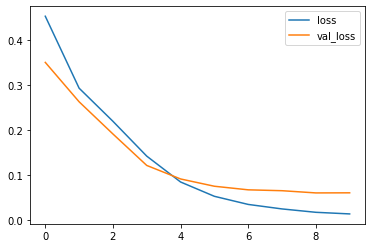

In [25]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

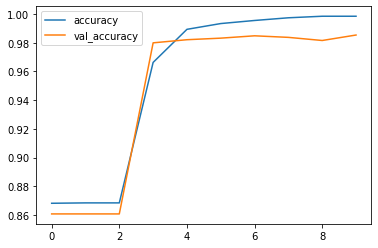

In [26]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()